In [1]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data 
from tqdm import tqdm 
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka

2024-08-15 10:56:19.907917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 10:56:19.908050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 10:56:20.054101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [3]:
# The batch size
BATCH_SIZE = 32

# Image dims 
IMAGE_SIZE = (100,100)                                   

# Buffer size
BUFFER = 518

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [4]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [5]:
train_path = "/kaggle/input/standard-ocr-dataset/data2/training_data/"
test_path  = "/kaggle/input/standard-ocr-dataset/data2/testing_data/"

In [6]:
# Get the class Names
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")

Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
print(f"Training Images : {sum([len(os.listdir(train_path + name)) for name in class_names])}")
print(f"Testing  Images : {sum([len(os.listdir(test_path + name)) for name in class_names])}")

Training Images : 20628
Testing  Images : 3242


In [8]:
def load_image(image_path:str):

    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_jpeg(contents=image_loaded, channels=3)
        
        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass

In [9]:
def load_data(root_path, class_names, trim=None, shuffle=False, split=None):

    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]
        
    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label
    
    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)
    
    # Split the data if needed
    if split is not None:
        
        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)
        
        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)
        
        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return data
        return train_set, test_set
    
    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return complete data
        return data_set

In [10]:
# Load Training data
train_ds = load_data(root_path=train_path, class_names=class_names, shuffle=True)

# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)
cls()

In [11]:
print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 20640
Validation Data Size : 672
Testing Data Size    : 2624


In [12]:
def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):
    
    '''
    This function is all about loading up our dataset and visualizing it with the help of matplotlib. By leveraging the power of
    this powerful visualization tool, we can quickly and easily analyze our images and extract valuable insights in the process. 
    The key feature of this function is its ability to display each image in our dataset in detail, giving us a clear and concise
    view of all the key details. 
    
    Arguments : 
        data    : This refers to the dataset from which the images and labels should be extracted.
        GRID    : This represents the total number of images broken up into rows and columns.
        FIGSIZE : This is a matplotlib property for setting the figure size.
        model   : In case if model is provided, then the function will make predictions and show the predictions as well.
    
    Returns : 
        None : It does not returns anything but it plots the images. 
    '''
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]
    
    # Get the data for data visualization
    images, labels = next(iter(data))
    
    # Iterate over data 
    for n_image, (image, label) in enumerate(zip(images, labels)):
        
        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')
        
        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)
        
        # Break the loop 
        if n_image+1>=n_images:
            break
    
    # Show the final plot
    plt.tight_layout()
    plt.show()

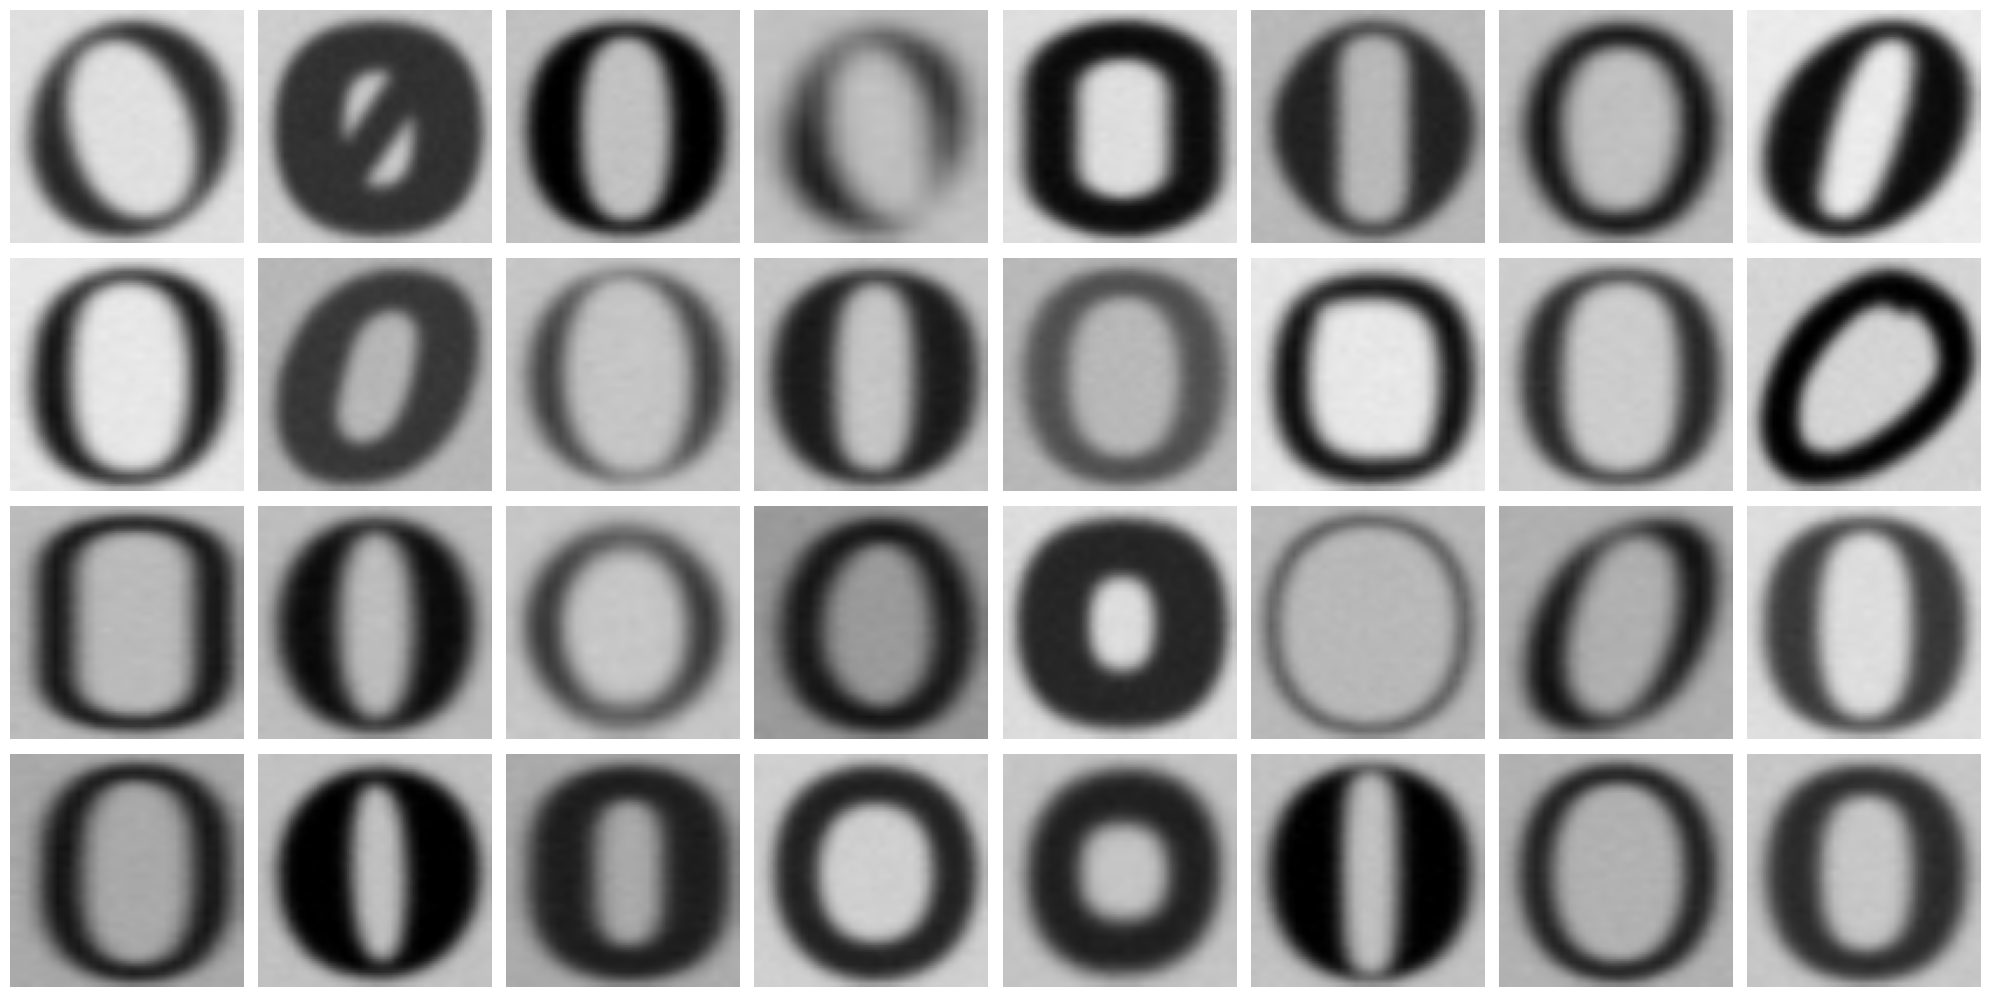

In [13]:
show_images(data=train_ds)


In [14]:
# All the backbones will be accessed through a name.
BACKBONE_NAMES = [
#     'ResNet50',
#     'ResNet50V2',
    'ResNet152V2',
    'Inception',
    'Xception',
    'MobileNet',
#     'DenseNet121',
#     'DenseNet169',
    'DenseNet201',
#     'EfficientNetB0',
    'EfficientNetB7',
#     'VGG16',
    'VGG19'
    
    
]

In [15]:
# Load the backbones
BACKBONES = [
#     tka.ResNet50(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
#     tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.ResNet152V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.InceptionV3(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.Xception(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),

    
    # Additional backbones
#     tka.DenseNet121(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
#     tka.DenseNet169(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.DenseNet201(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
#     tka.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
#     tka.VGG16(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.VGG19(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
]

for backbone in BACKBONES:
    backbone.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipykernel_34/2895391987.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# store the Backbone histories.
BACKBONE_HISTORIES = []

# Iterate over the backbones
for name, backbone in zip(BACKBONE_NAMES, BACKBONES):
    
    # Show
    print(f'BACKBONE : {name.title()}\n')
    
    # Create a simple model architecture.
    dummy_model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone, 
        layers.GlobalAveragePooling2D(name="GAP"),
        layers.Dropout(0.2, name="DropoutLayer"),
        layers.Dense(len(class_names), activation='softmax', name="OutputLayer")
    ], name=name.strip().title())
    
    # Show the summary
    print('-'*100)
    print("Model Summary\n")
    dummy_model.summary()
    print("\n")
    print('-'*100)
    
    # Compile the model.
    dummy_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    # Train the model
    print("\n")
    print('-'*100)
    print("Model Training\n")
    history = dummy_model.fit(train_ds, validation_data=test_ds, epochs=10)
    print("\n")
    print('-'*100)
    
    # Store the history
    BACKBONE_HISTORIES.append(
        pd.DataFrame(history.history)
    )
    
    # clear the output.
    cls()

In [17]:
# BACKBONE_HISTORIES[4]
# # BACKBONE_NAMES[3]          

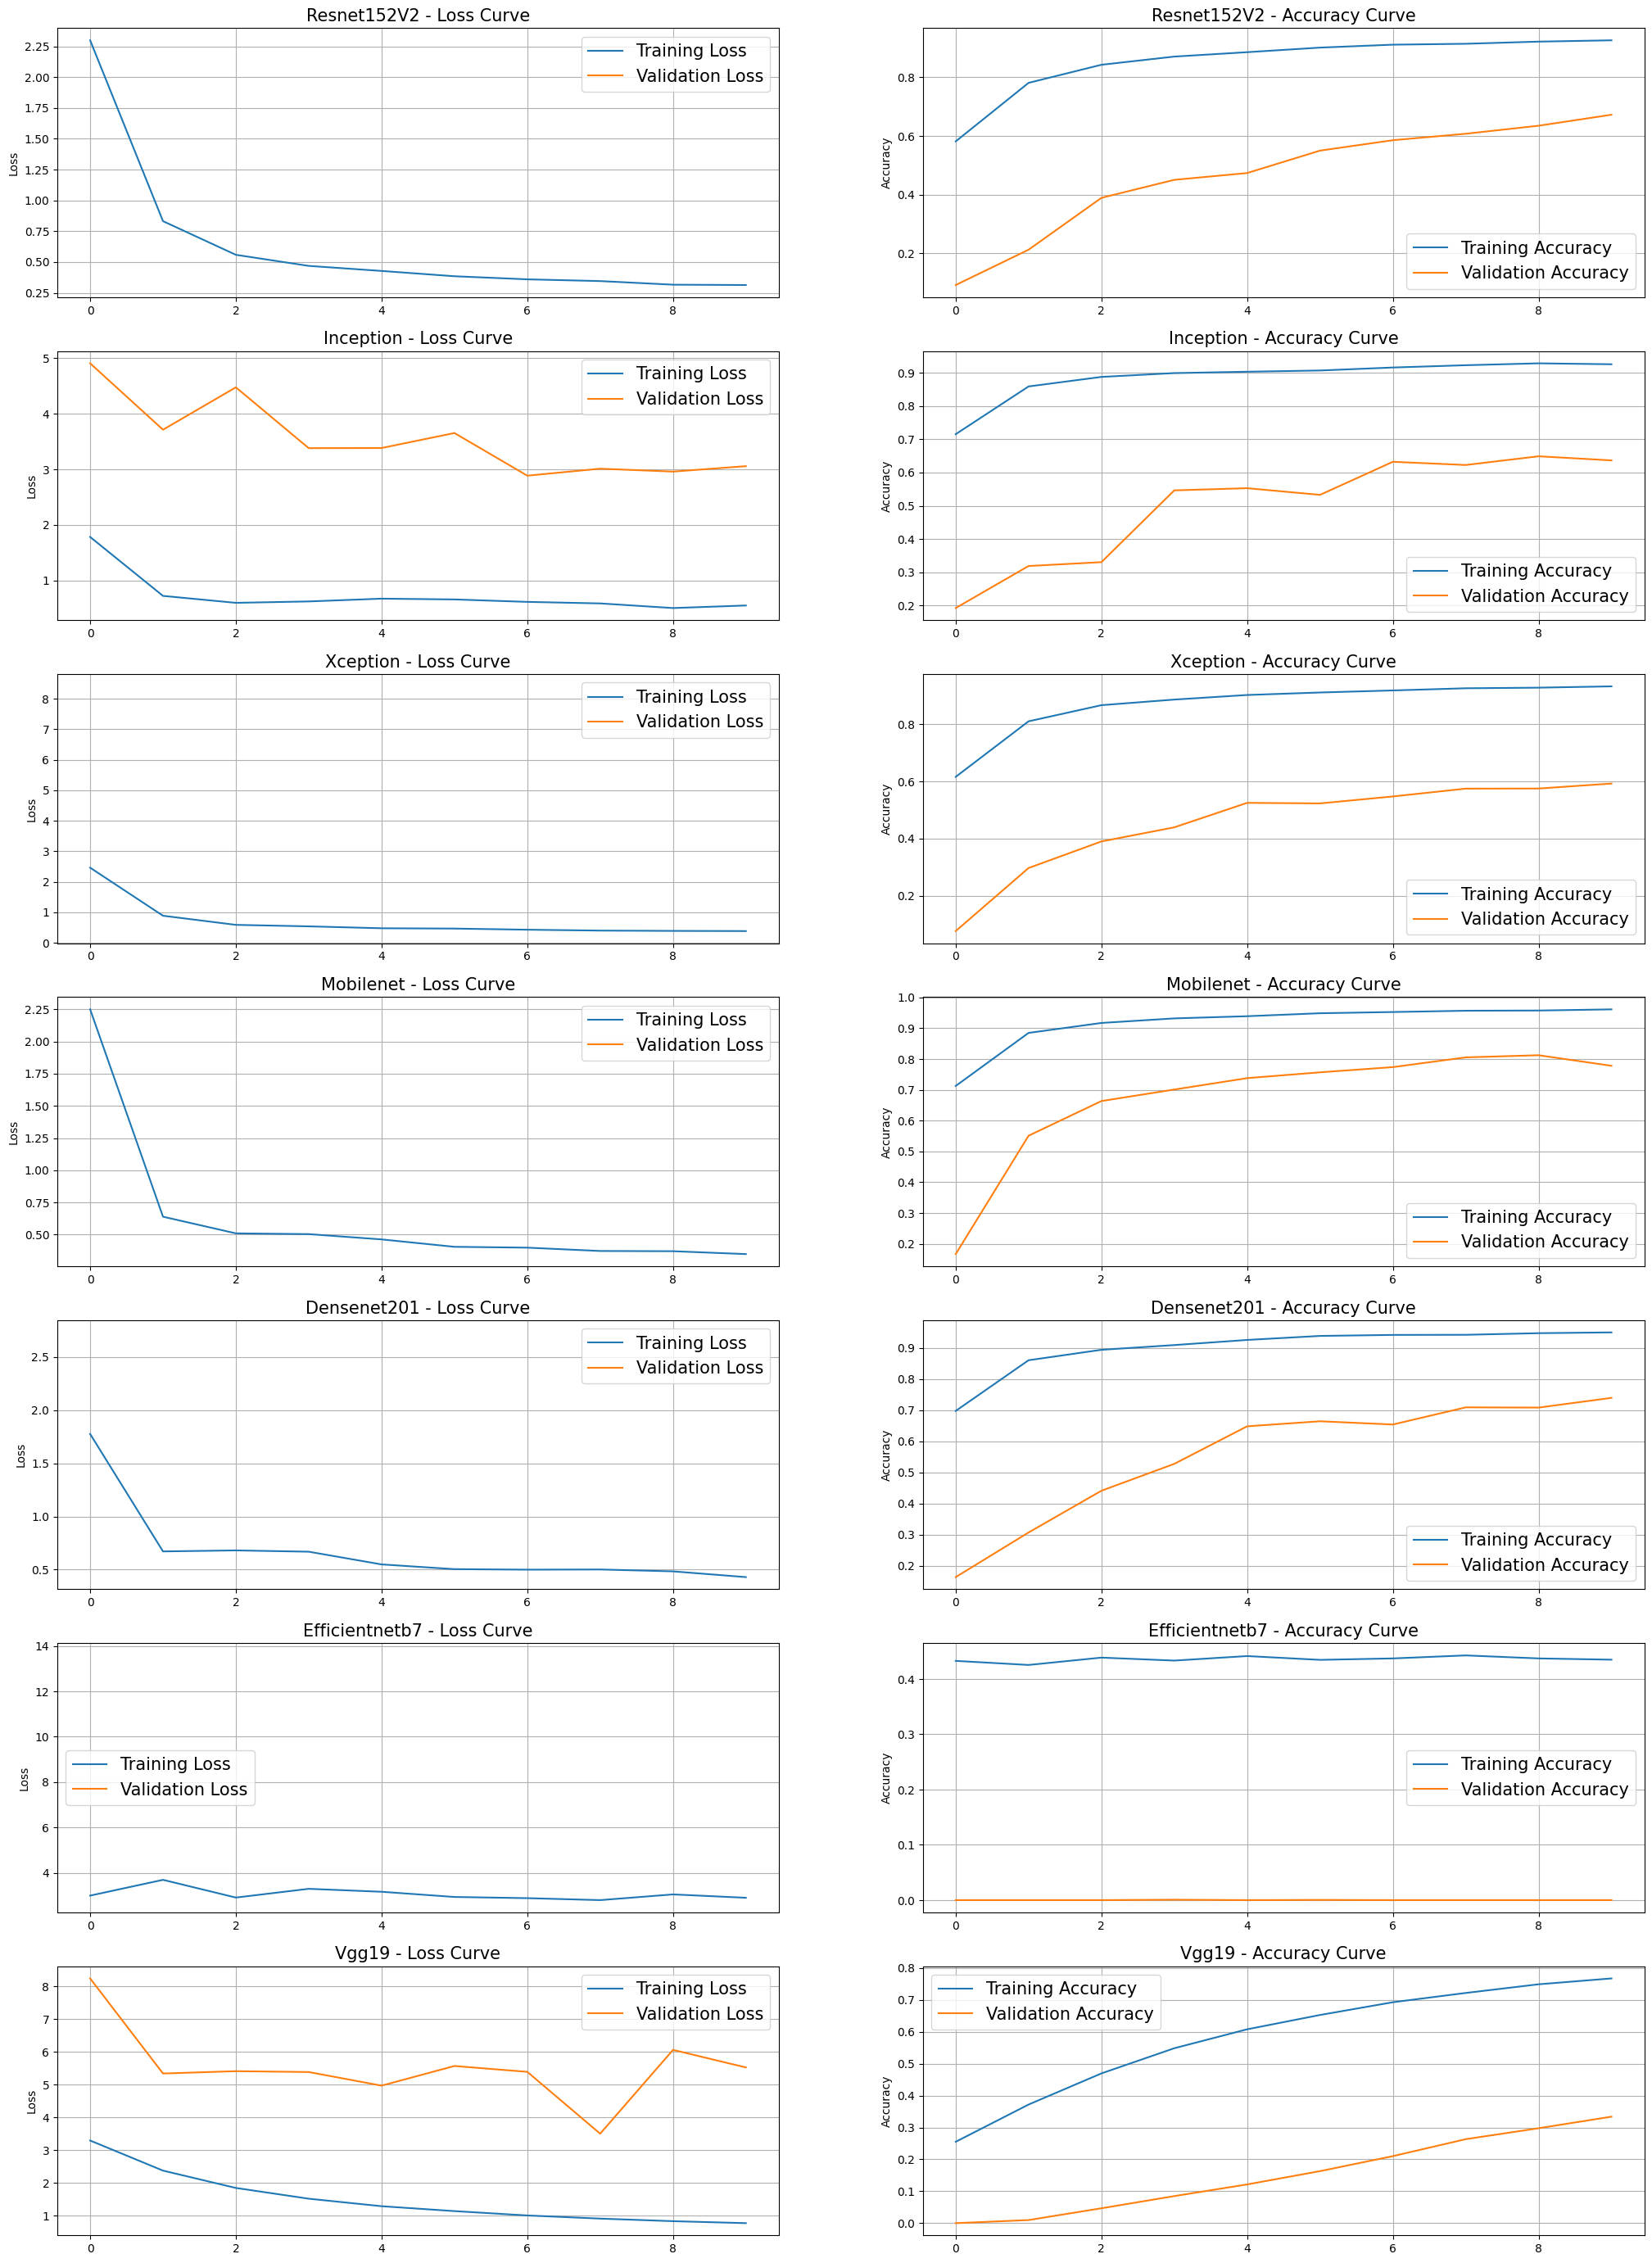

In [18]:
# Plotting configurations
plt.figure(figsize=(25, 35))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):
    
    # subplot of the Backbone Learning curve.
    plt.subplot(7, 2, index)
    plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
    plt.plot(history['loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.ylabel("Loss")
    plt.legend(fontsize=15)
    plt.grid()

    plt.subplot(7, 2, index+1)
    plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
    plt.plot(history['accuracy'], label="Training Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.legend(fontsize=15)
    plt.grid()
    
    # update index
    index+=2

# show the final plot.
plt.savefig("BackboneComparision-All.png")
plt.show()

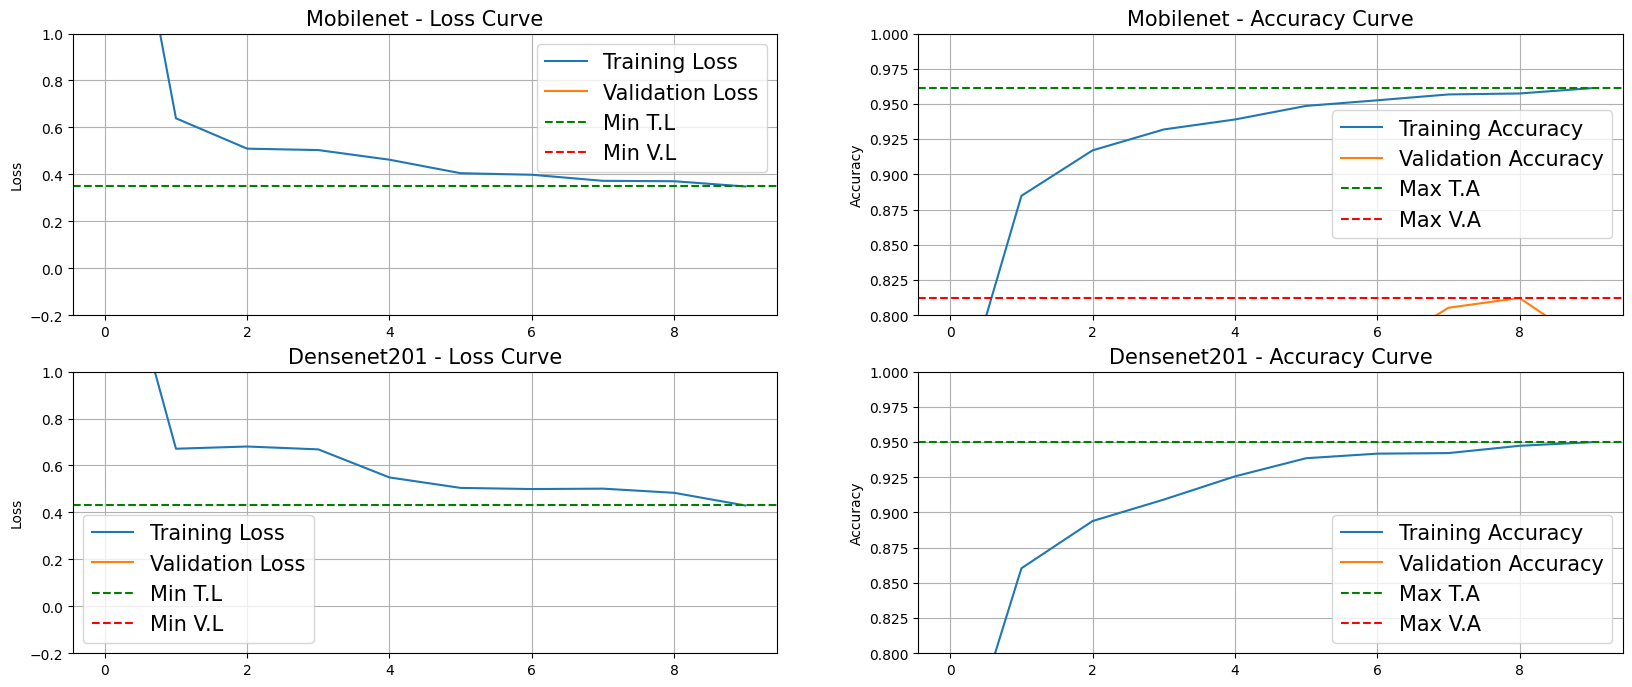

In [19]:
# Name of the top 3 backbones.
TOP_BACKBONES = ['MobileNet', 'DenseNet201']

# Plotting configurations
plt.figure(figsize=(20, 30))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):
    
    if name in TOP_BACKBONES:
        # subplot of the Backbone Learning curve.
        plt.subplot(7, 2, index)
        plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
        plt.plot(history['loss'], label="Training Loss")
        plt.plot(history['val_loss'], label="Validation Loss")
        plt.axhline(y=min(history['loss']), label="Min T.L", color='g', linestyle='--')
        plt.axhline(y=min(history['val_loss']), label="Min V.L", color='r', linestyle='--')
        plt.ylabel("Loss")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=-0.2, top=1)

        plt.subplot(7, 2, index+1)
        plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
        plt.plot(history['accuracy'], label="Training Accuracy")
        plt.plot(history['val_accuracy'], label="Validation Accuracy")
        plt.axhline(y=max(history['accuracy']), label="Max T.A", color='g', linestyle='--')
        plt.axhline(y=max(history['val_accuracy']), label="Max V.A", color='r', linestyle='--')
        plt.ylabel("Accuracy")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=0.8, top=1)

        # update index
        index+=2

# show the final plot.
plt.savefig("BackboneComparision-Top2-CloseLook.png")
plt.show()

In [48]:
# Using the best validation accuracy as baseline accuracy.
BASELINE_ACC = max(BACKBONE_HISTORIES[BACKBONE_NAMES.index('MobileNet')]['val_accuracy'])

# Similarly, using the best validation loss as the baseline loss.
BASELINE_LOSS = min(BACKBONE_HISTORIES[BACKBONE_NAMES.index('MobileNet')]['val_loss'])

print('--'*50)
print(" "*25 + f"Best Loss : {np.round(BASELINE_LOSS, decimals=4)}; Best Accuracy : {np.round(BASELINE_ACC, decimals=3)*100}%")
print('--'*50)

----------------------------------------------------------------------------------------------------
                         Best Loss : nan; Best Accuracy : 81.2%
----------------------------------------------------------------------------------------------------


In [68]:
# Evaluation on Test Set
dummy_model.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1852 - loss: 2.4776


[5.910025596618652, 0.3388589024543762]

In [49]:
def build_model(hp):
    
    # Backbone
    backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
    backbone.trainable = False
    
    # Base Model
    model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,                                                            
        layers.GlobalAveragePooling2D(name="GAP"),
    ], name=name.strip().title())
    
    # Params to tweak
    for i in range(hp.Choice('n_layers', [1,2,4])):
        model.add(layers.Dense(hp.Choice('n_units', [64, 256])))
    model.add(layers.Dropout(hp.Choice('rate', [0.2,0.4])))
    
    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))
    
    # Compile the model.
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    return model

In [50]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_loss', project_name='MobileNet',max_trials=5)

# Start hyperparameter search.
tuner.search(
    train_ds, 
    validation_data=valid_ds,
    epochs = 5
)

Reloading Tuner from ./MobileNet/tuner0.json


In [51]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]

# best_model.build(input_shape=(*IMAGE_SIZE, 3))

/tmp/ipykernel_34/2153292074.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))


In [52]:
# Best Model Summary
best_model.summary()

Model: "Vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 3, 3, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GAP (GlobalAveragePooling2D)    │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,296,804 (12.58 MB)

 Trainable params: 67,940 (265.39 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [53]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
best_hyperparameters.values

{'n_layers': 1, 'n_units': 64, 'rate': 0.2}

In [54]:
# Training the model
best_model_history = best_model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=10,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('MobileNet-numbers.keras', save_best_only=True)
    ]
)

Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9364 - loss: 0.3078 - val_accuracy: 0.9167 - val_loss: 0.4556
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9566 - loss: 0.1784 - val_accuracy: 0.9120 - val_loss: nan
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9503 - loss: 0.2495 - val_accuracy: 0.8889 - val_loss: 0.3715
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9576 - loss: 0.2181 - val_accuracy: 0.8966 - val_loss: 0.4191
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9573 - loss: 0.1932 - val_accuracy: 0.9506 - val_loss: 0.2340
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9563 - loss: 0.2364 - val_accuracy: 0.9429 - val_loss: 0.3437
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9543 - loss: 0.2567 - val_accuracy: 0.9460 - val_loss: 0.2672
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9574 - loss: 0.2668 - val_accuracy: 0.9

In [55]:
# Valid Data
best_model.evaluate(valid_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9689 - loss: 0.1312


[0.18043744564056396, 0.9629629850387573]

In [56]:
# Backbone
backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
backbone.trainable = True

# Base Model
model = keras.Sequential(layers=[
    layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
    backbone,                                                           
    layers.GlobalAveragePooling2D(name="GAP"),
    layers.Dense(64),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# History 
history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=20,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('MobileNet-numbers-2.keras', save_best_only=True)
    ]
)

/tmp/ipykernel_34/2390038401.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))


Epoch 1/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0833 - loss: 4.8626 - val_accuracy: 0.4846 - val_loss: nan
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.2416 - loss: 3.2692 - val_accuracy: 0.7670 - val_loss: 0.8512
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.3808 - loss: 2.4842 - val_accuracy: 0.8812 - val_loss: 0.4597
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5056 - loss: 1.9768 - val_accuracy: 0.9228 - val_loss: 0.2853
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6012 - loss: 1.6019 - val_accuracy: 0.9444 - val_loss: 0.2322
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.6931 - loss: 1.2524 - val_accuracy: 0.9660 - val_loss: 0.1632
Epoch 7/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7516 - loss: 1.0536 - val_accuracy: 0.9676 - val_loss: 0.1761
Epoch 8/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7943 - loss: 0.8870 - val

In [57]:
# Test data
best_model.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5204 - loss: nan


[nan, 0.6441788673400879]

In [58]:
model.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7961 - loss: nan


[nan, 0.8974556922912598]

In [59]:
# Test data
best_model.evaluate(valid_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9291 - loss: 0.2843


[0.2867729067802429, 0.9336419701576233]

In [60]:
model.evaluate(valid_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9912 - loss: 0.0532


[0.05499213933944702, 0.9907407164573669]

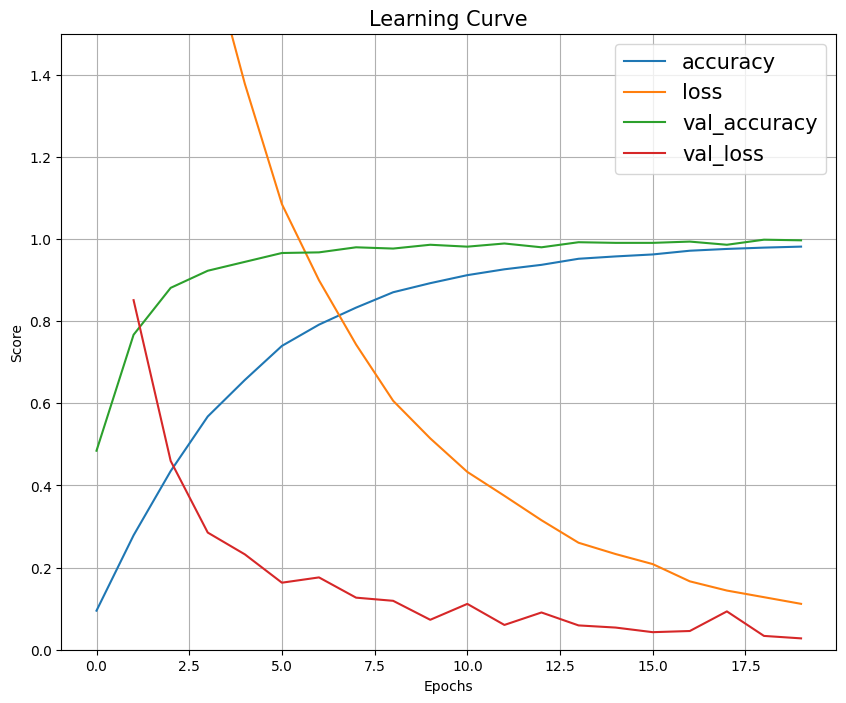

In [61]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [67]:
# Evaluation on Test Set
model.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8043 - loss: nan


[nan, 0.8993831872940063]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

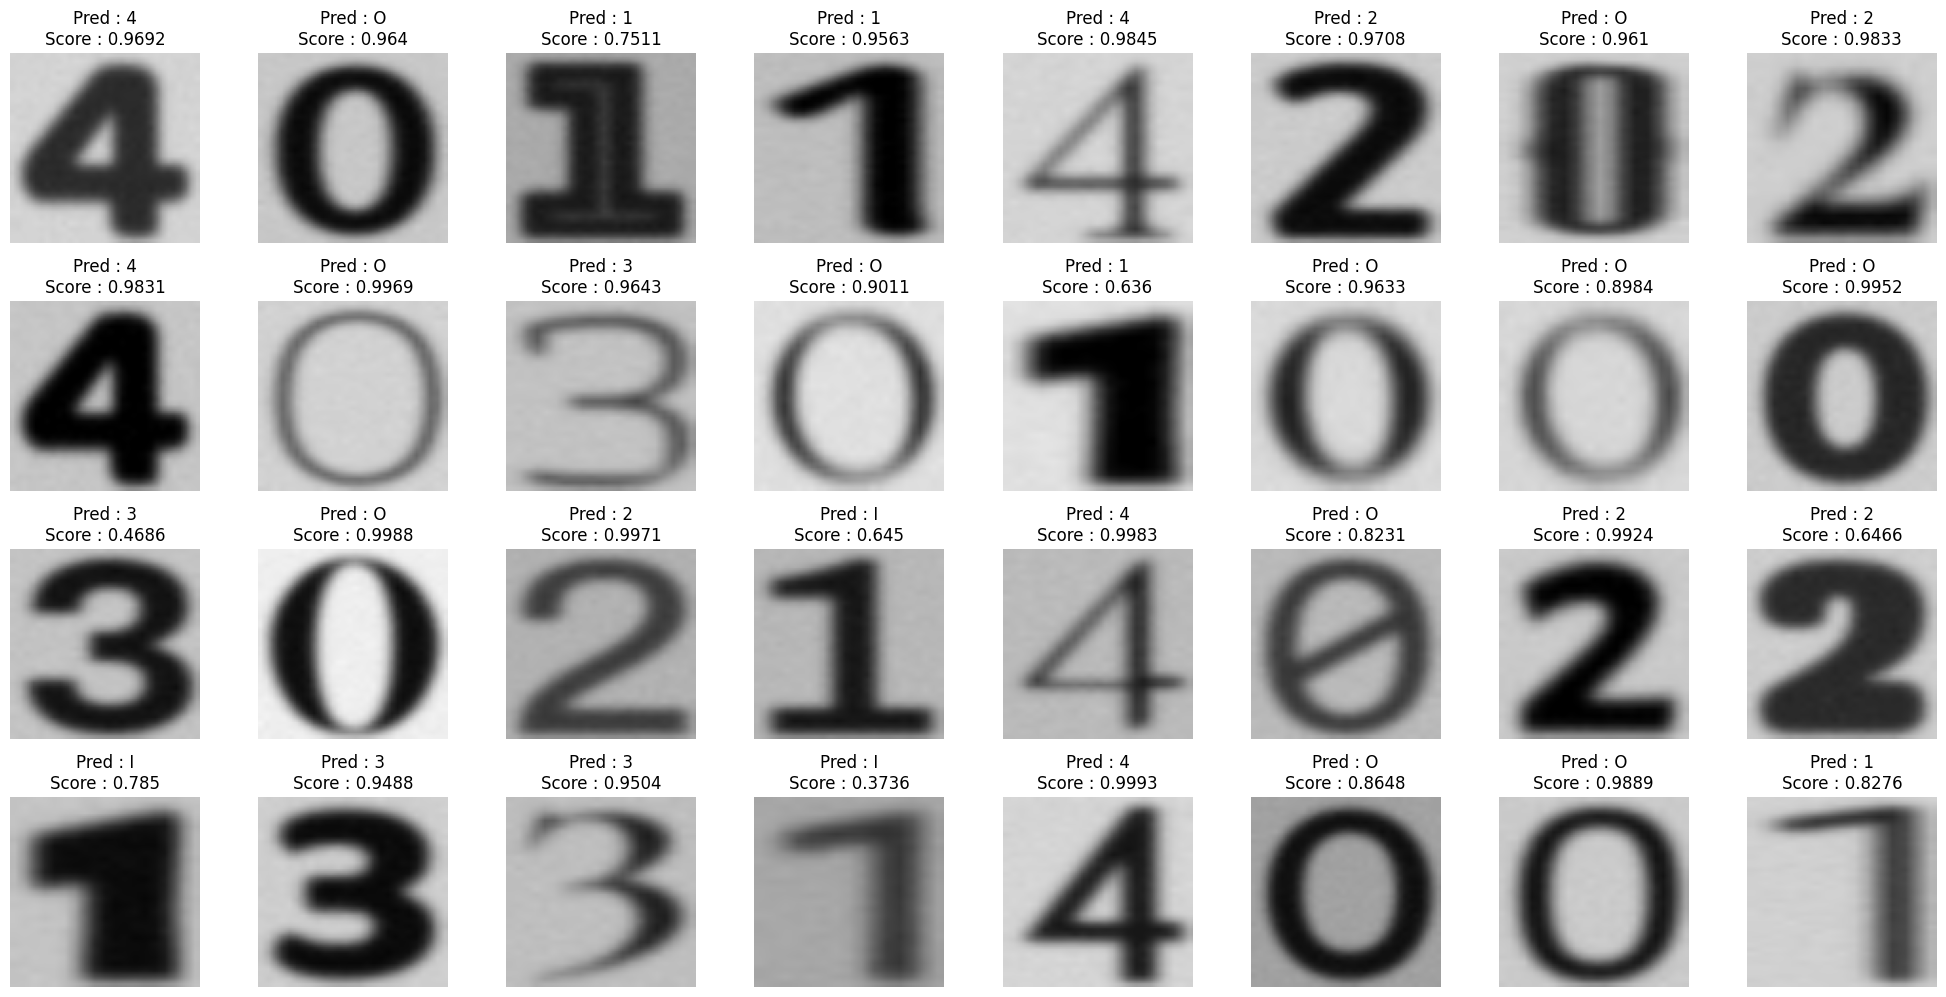

In [63]:
show_images(data=test_ds, model=model)